# VAF distribution of UKB variants in the population

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import seaborn as sns

## Import mutations

In [2]:
# Upload mutations dataframe including the flanking nt per mutation (NOT PROVIDED)
# File generated in 2_Mutation_overview/MutSig.ipynb
file_name="../2_Mutation_overview/boostDM_all_context_nonHNALL.txt.gz" 
boostDMmut = pd.read_csv(file_name,sep="\t", compression='gzip')
boostDMmut.columns
len(boostDMmut)

/tmp/jobs/jramis/9874679/ipykernel_56249/4007443446.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  boostDMmut = pd.read_csv(file_name,sep="\t", compression='gzip')


201857

In [3]:
# Select those mutations in cases that only hav3e one mutation
num_mut = boostDMmut['patient'].value_counts().reset_index()
uni_mut_patients = num_mut[num_mut['patient']==1]['index'].tolist()
len(uni_mut_patients)
len(num_mut[num_mut['patient']>1]['index'].tolist())

34646

In [4]:
boostDMmut = boostDMmut[boostDMmut['patient'].isin(uni_mut_patients)]

In [5]:
# Select now those that are frequent in the cohort (>=30)
mut_ids = boostDMmut['ID2'].value_counts().reset_index()
mut_ids
mut_ids = mut_ids[mut_ids['ID2']>=30]['index'].tolist()
len(mut_ids)

392

In [6]:
# More filters
boostDMmut_20 = boostDMmut[boostDMmut['DP']>=50]
mut_ids = boostDMmut_20['ID2'].value_counts().reset_index()
mut_ids = mut_ids[mut_ids['ID2']>=10]['index'].tolist()
len(mut_ids)

2118

In [12]:
boostDMmut.to_csv("boostDM_all_context_nonHNALL_unique.txt.gzip", index=False, compression='gzip', sep='\t')

In [14]:
# Upload the the file above
file_name="boostDM_all_context_nonHNALL_unique.txt.gzip"

In [15]:
#create a dictionary of DNMT3A R288H (with row_count as key) new set of mutations
# Example
# Dict = {row: (patient_id, VAF, mut_ID, age_group)}

with gzip.open(file_name,'rt',encoding='utf-8') as file:
    row_count = 0
    DNMT3A_R882H_all={} #dictionary of DNMTA missense and nonsense results
    for line in file:
        line = line.strip("\r\n").split("\t")
        if row_count>0: #ignore the header of the CSV file
            if line[12]=='DNMT3A': #only look at the DNMT3A results
                VAF = line[9] #VAF
                ID = line[-11] #participant ID
                age_group = line[-4]
                mutation_type = line[-6] #whether the variant is missense or nonsense or synonymous
                if mutation_type == '2-25234373-T':
                    DNMT3A_R882H_all[row_count]=(ID, VAF, mutation_type, age_group)
        row_count=row_count+1
len(DNMT3A_R882H_all)

877

In [17]:
DNMT3A_R882H_all_sorted = sorted(DNMT3A_R882H_all.items(), key=lambda x: x[1][1], reverse=True) #sort the results by VAF
len(DNMT3A_R882H_all_sorted)

877

In [18]:
#create a dictionary with row_count as key, same as above
with gzip.open(file_name,'rt',encoding='utf-8') as file:
    row_count = 0
    all_mutations={} #dictionary of DNMTA missense and nonsense results
    for line in file:
        line = line.strip("\r\n").split("\t")
        if row_count>0: #ignore the header of the CSV file
            VAF = line[9] #VAF
            ID = line[-11] #participant ID
            age_group = line[-4]
            mutation_type = line[-6] #whether the variant is missense or nonsense or synonymous
            all_mutations[row_count]=(ID, VAF, mutation_type, age_group)
        row_count=row_count+1
all_mutations_sorted = sorted(all_mutations.items(), key=lambda x: x[1][1], reverse=True) #sort the results by VAF
print(len(all_mutations_sorted))

113415


In [19]:
# Indicate the number of individuals
used_individuals_500k = 467202

Function to plot the distribution of vafs for a particular variant among all ages

In [9]:
def hist_data_for_plot(study_VAFs, study_total, bin_size, color, study_name, trim_VAF_value, axis): #Function to plot histograms of each study, given VAFs and study total
    log_VAFs = []
    for k, v in study_VAFs: #iterates over the key (i.e. row_count) and value (i.e. ID, VAF, AA, age, mutation_type etc.) for each study's missense_nonsense dictionary
        log_VAFs.append(np.log10(float(v[1]))) #v[1] is the VAF in each study's dictionary - store the log of this value in log_VAFs list.
        
    normed_value = study_total #the data will be normalised by the number of individuals in the study
    hist, bins = np.histogram(log_VAFs, bins=bin_size, range=(min(log_VAFs),max(log_VAFs))) #create a histogram (number of bins is determined by "bin_size")
    widths = np.diff(bins)
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value) #normalise the histogram by the number of individuals in the study
    print('bin edges (log) ('+str(study_name)+') = ',bins)
    print('densities in each bin ('+str(study_name)+') = ',hist)
    print()
    
    axis.bar(((bins[:-1])+widths/2), normalised_hist, widths, log = True, color = color, alpha = 0.5, edgecolor='k', lw = 0.4, label= study_name) #plot the histogram and label with study name
    
    #set min and max for x and y axis
    axis.set_xlim(-4, 0)
    
    ax_ymax = 10**0
    axis.set_ylim(10**-5, ax_ymax)
    
    axisfont=12
    titlefont=20
    subtitlefont = 15
    axislabelfont=15
    legendfont = 11
    tpfont = 12

    #Plot the line where the data is trimmed
    x_range = []
    y_range = np.linspace(10**-5, ax_ymax)
    for i in y_range:
        x_range.append(trim_VAF_value) #trim_VAF_value was chosen as the edge of the bin where the VAF densities start to fall off
    
    axis.plot(x_range, y_range, color = 'k', lw =2, linestyle = ':')
    
    axis.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 5)
    axis.set_ylabel('probability density', fontsize = axislabelfont)
    
    x_major_ticks = [-4, -3, -2, -1, -0.3]
    x_major_tick_labels = ["0.01", "0.1","1", "10", "50"]
    axis.set_xticks(x_major_ticks)
    axis.set_xticklabels(x_major_tick_labels, fontsize = axisfont)

    y_major_ticks = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0]
    y_major_tick_labels = ["$10^{-5}$","$10^{-4}$", "$10^{-3}$","$10^{-2}$", "$10^{-1}$", "$10^{0}$"]
    axis.set_yticks(y_major_ticks)
    axis.set_yticklabels(y_major_tick_labels, fontsize = axisfont)

    #Only show the bottom and left axis lines
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # Axis title
    axis.set_title(study_name, fontsize = 14, fontweight = 'semibold', y=1.04, transform=axis.transAxes)
    
    return axis #return the histogram

## 1. VAF density for all the cohort 

bin edges (log) (all) =  [-1.93449845 -1.85711851 -1.77973858 -1.70235864 -1.6249787  -1.54759876
 -1.47021882 -1.39283888 -1.31545895 -1.23807901 -1.16069907 -1.08331913
 -1.00593919 -0.92855926 -0.85117932 -0.77379938 -0.69641944 -0.6190395
 -0.54165957 -0.46427963 -0.38689969 -0.30951975 -0.23213981 -0.15475988
 -0.07737994  0.        ]
densities in each bin (all) =  [2.0000e+00 3.9000e+01 1.7200e+02 6.7100e+02 1.6760e+03 4.7710e+03
 1.8202e+04 1.5996e+04 1.2731e+04 8.5040e+03 5.4430e+03 3.5820e+03
 2.4340e+03 1.9290e+03 1.6020e+03 1.2000e+03 9.0200e+02 9.7000e+02
 1.8040e+03 5.4070e+03 1.2801e+04 1.0402e+04 2.0410e+03 1.0800e+02
 2.6000e+01]



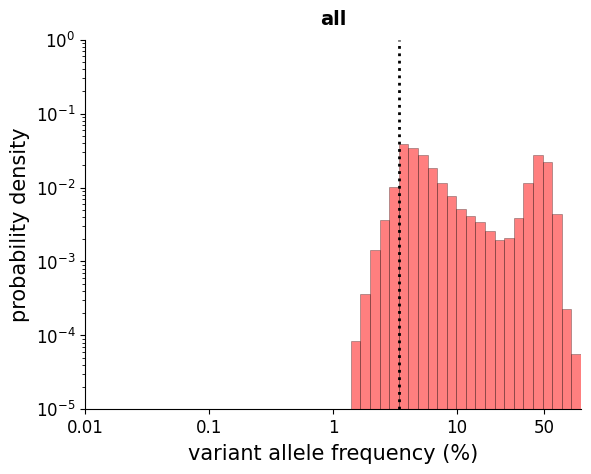

In [11]:
f, ax1 = plt.subplots()
#binmethod = 15
limit_500k = -1.47021882
binmethod = 'doane' #An improved version of Sturges’ estimator that works better with non-normal datasets.
DNMT3Acolor = "red"
#using the function "hist_data_for_plot" to plot histogram for each study
hist_data_for_plot(all_mutations_sorted, used_individuals_500k, binmethod, DNMT3Acolor, 'all', limit_500k, ax1)
plt.show()
#plt.savefig("DNMT3A_R882H_vafs_normalized.png")

In [20]:
# Check the detection threshold
10**(-1.47021882)

0.03386734719486137

## 2. VAF density for DNMT3A-R882H

bin edges (log) (all DNMT3A) =  [-1.69019608 -1.58786524 -1.4855344  -1.38320356 -1.28087271 -1.17854187
 -1.07621103 -0.97388019 -0.87154935 -0.76921851 -0.66688767 -0.56455683
 -0.46222598 -0.35989514 -0.2575643 ]
densities in each bin (all DNMT3A) =  [  3.  34. 119. 133.  97.  96.  72.  67.  65.  57.  51.  43.  26.  14.]



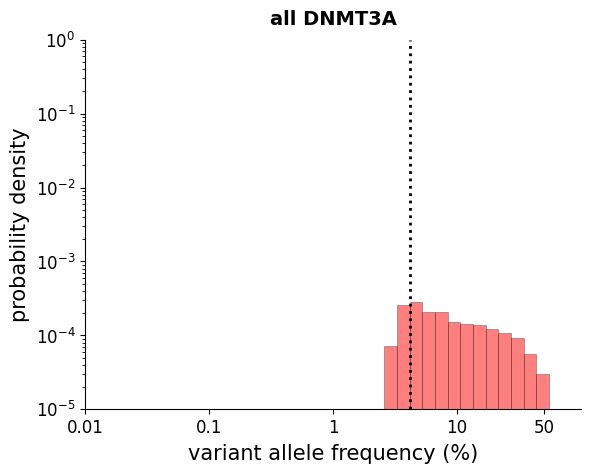

In [14]:
f, ax1 = plt.subplots()
#binmethod = 15
limit_500k = -1.38320356
binmethod = 'doane' #An improved version of Sturges’ estimator that works better with non-normal datasets.
DNMT3Acolor = "red"
#using the function "hist_data_for_plot" to plot histogram for each study
hist_data_for_plot(DNMT3A_R882H_all_sorted, used_individuals_500k, binmethod, DNMT3Acolor, 'all DNMT3A', limit_500k, ax1)
plt.show()
#plt.savefig("DNMT3A_R882H_vafs_normalized.png")

## 3. Plot distribution for Gene

In [15]:
#create a dictionary of DNMT3A R288H (with row_count as key) new set of mutations
with gzip.open(file_name,'rt',encoding='utf-8') as file:
    row_count = 0
    UKB_all={} #dictionary of DNMTA missense and nonsense results
    for line in file:
        line = line.strip("\r\n").split("\t")
        if row_count>0: #ignore the header of the CSV file
            gene = line[12]
            VAF = line[9] #VAF
            ID = line[-11] #participant ID
            age_group = line[-4]
            mutation_type = line[-6] #whether the variant is missense or nonsense or synonymous
            UKB_all[row_count]=(ID, VAF, mutation_type, age_group, gene)
        row_count=row_count+1
len(UKB_all)

113415

In [21]:
# Gene-specific threshold from extracted from the plots below
limit_500k = {
    'All':-1.47021882,
    'DNMT3A':-1.44891098,
    'TET2':-1.43749715,
    'ASXL1':-1.47937168,
    'CHEK2':-1.22874631,
    'TP53':-1.43879269,
    'PPM1D':-1.46639745,
    'SRSF2':-1.42301253,
    'SF3B1':-1.25316058,
    'U2AF1':-1.46483105,
    'GNAS':-1.42188989,
    'IDH2':-1.26422133,
    'MDM4':-1.20414359,
}

bin edges (log) (DNMT3A) =  [-1.87506126 -1.78983121 -1.70460115 -1.61937109 -1.53414103 -1.44891098
 -1.36368092 -1.27845086 -1.1932208  -1.10799075 -1.02276069 -0.93753063
 -0.85230057 -0.76707052 -0.68184046 -0.5966104  -0.51138034 -0.42615029
 -0.34092023 -0.25569017 -0.17046011 -0.08523006  0.        ]
densities in each bin (DNMT3A) =  [1.100e+01 6.400e+01 3.220e+02 7.390e+02 2.884e+03 5.044e+03 3.382e+03
 2.028e+03 1.509e+03 1.064e+03 8.660e+02 7.250e+02 6.110e+02 4.240e+02
 3.380e+02 2.890e+02 2.920e+02 5.480e+02 6.150e+02 1.030e+02 3.000e+00
 2.000e+00]



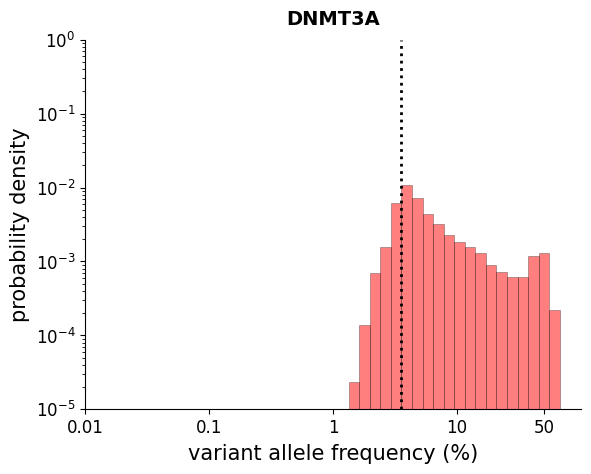

bin edges (log) (TET2) =  [-1.77573178 -1.69117312 -1.60661446 -1.52205581 -1.43749715 -1.3529385
 -1.26837984 -1.18382118 -1.09926253 -1.01470387 -0.93014522 -0.84558656
 -0.7610279  -0.67646925 -0.59191059 -0.50735194 -0.42279328 -0.33823462
 -0.25367597 -0.16911731 -0.08455866  0.        ]
densities in each bin (TET2) =  [3.000e+00 2.200e+01 1.020e+02 1.420e+03 4.026e+03 3.870e+03 2.397e+03
 1.218e+03 6.210e+02 4.840e+02 4.550e+02 4.650e+02 2.990e+02 1.990e+02
 1.920e+02 6.070e+02 2.023e+03 2.818e+03 7.650e+02 2.400e+01 8.000e+00]



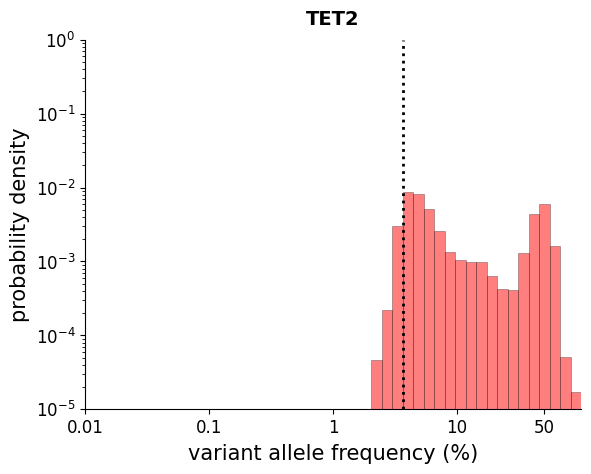

bin edges (log) (ASXL1) =  [-1.84921461 -1.75675388 -1.66429315 -1.57183242 -1.47937168 -1.38691095
 -1.29445022 -1.20198949 -1.10952876 -1.01706803 -0.9246073  -0.83214657
 -0.73968584 -0.64722511 -0.55476438 -0.46230365 -0.36984292 -0.27738219
 -0.18492146 -0.09246073  0.        ]
densities in each bin (ASXL1) =  [  18.  129.  472.  971. 5386. 2607. 1137.  446.  210.  137.  108.  102.
   70.   65.  174. 1357. 4317. 1465.   33.    8.]



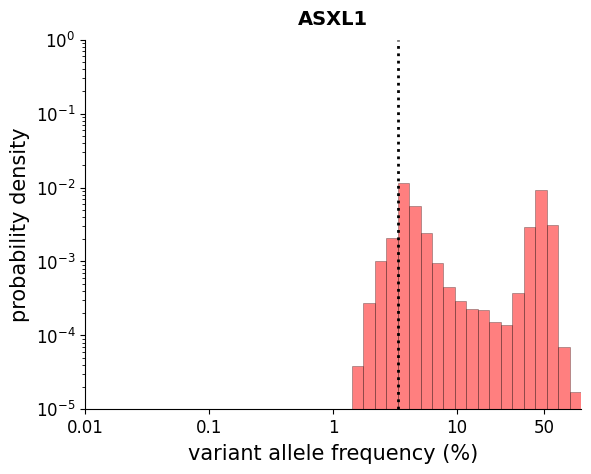

bin edges (log) (CHEK2) =  [-1.80163235 -1.70615134 -1.61067033 -1.51518933 -1.41970832 -1.32422732
 -1.22874631 -1.1332653  -1.0377843  -0.94230329 -0.84682228 -0.75134128
 -0.65586027 -0.56037927 -0.46489826 -0.36941725 -0.27393625 -0.17845524
 -0.08297424]
densities in each bin (CHEK2) =  [1.000e+00 0.000e+00 7.000e+00 1.020e+02 3.140e+02 4.310e+02 4.800e+02
 3.690e+02 2.410e+02 1.500e+02 1.150e+02 1.270e+02 2.410e+02 4.160e+02
 1.032e+03 1.431e+03 5.720e+02 7.500e+01]



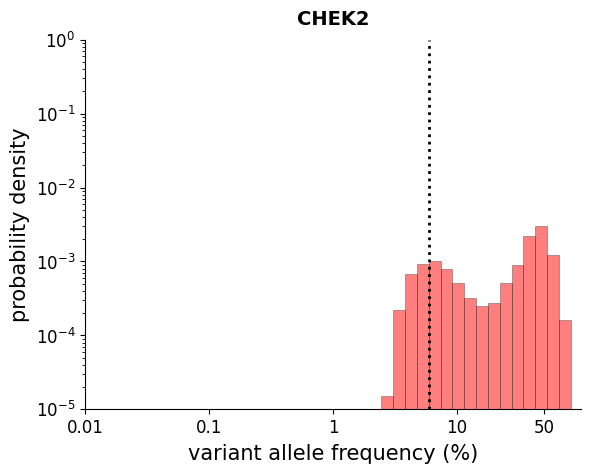

bin edges (log) (TP53) =  [-1.70472233 -1.61607912 -1.5274359  -1.43879269 -1.35014947 -1.26150626
 -1.17286305 -1.08421983 -0.99557662 -0.9069334  -0.81829019 -0.72964697
 -0.64100376 -0.55236054 -0.46371733 -0.37507411 -0.2864309  -0.19778768
 -0.10914447]
densities in each bin (TP53) =  [  7.  27. 387. 981. 904. 558. 313. 146.  63.  34.  21.  25.  24. 103.
 302. 599. 286.  38.]



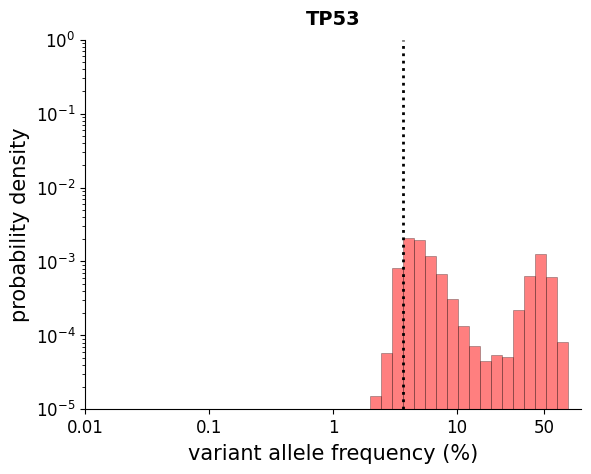

bin edges (log) (PPM1D) =  [-1.82173182 -1.73289823 -1.64406464 -1.55523105 -1.46639745 -1.37756386
 -1.28873027 -1.19989668 -1.11106309 -1.0222295  -0.9333959  -0.84456231
 -0.75572872 -0.66689513 -0.57806154 -0.48922795 -0.40039435 -0.31156076
 -0.22272717 -0.13389358]
densities in each bin (PPM1D) =  [  12.   53.  142.  564. 1909. 1158.  518.  272.  150.  163.  125.   72.
   29.   14.   66.  322. 1236.  868.   86.]



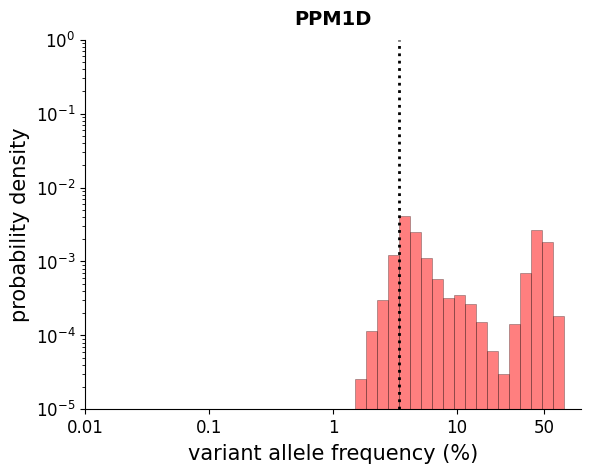

bin edges (log) (SRSF2) =  [-1.78532984 -1.69475051 -1.60417118 -1.51359186 -1.42301253 -1.3324332
 -1.24185388 -1.15127455 -1.06069522 -0.9701159  -0.87953657 -0.78895724
 -0.69837792 -0.60779859 -0.51721927 -0.42663994 -0.33606061 -0.24548129
 -0.15490196]
densities in each bin (SRSF2) =  [  9.  25.  78. 793. 969. 508. 196.  51.  27.  17.  12.  20.  20.  20.
  49. 162. 227.  36.]



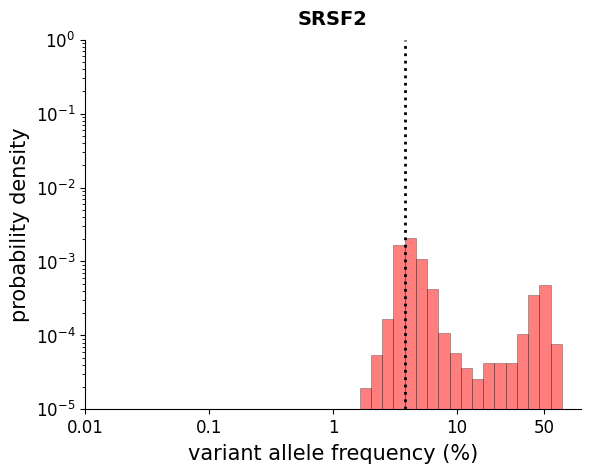

bin edges (log) (SF3B1) =  [-1.58733673 -1.5037927  -1.42024866 -1.33670462 -1.25316058 -1.16961654
 -1.0860725  -1.00252846 -0.91898443 -0.83544039 -0.75189635 -0.66835231
 -0.58480827 -0.50126423 -0.41772019 -0.33417615 -0.25063212 -0.16708808
 -0.08354404  0.        ]
densities in each bin (SF3B1) =  [  4. 103. 308. 733. 904. 887. 535. 332. 182. 136.  98.  41.  45.  98.
 210. 259.  90.   7.   1.]



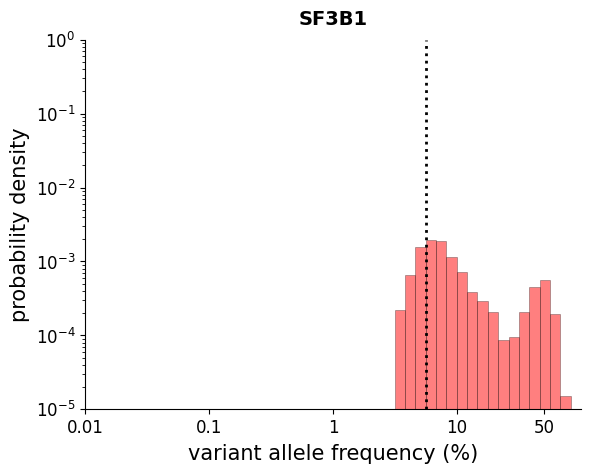

bin edges (log) (U2AF1) =  [-1.93449845 -1.84056497 -1.74663149 -1.65269801 -1.55876453 -1.46483105
 -1.37089757 -1.27696409 -1.18303061 -1.08909713 -0.99516365 -0.90123016
 -0.80729668 -0.7133632  -0.61942972 -0.52549624 -0.43156276 -0.33762928
 -0.2436958  -0.14976232]
densities in each bin (U2AF1) =  [  2.  14.  51. 123. 415. 821. 802. 378. 157.  53.  18.  11.   8.   4.
   7.  11.  70.  83.  14.]



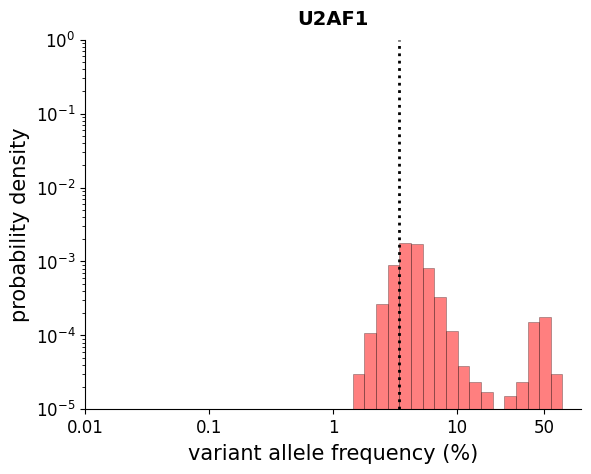

bin edges (log) (GNAS) =  [-1.80106053 -1.70626787 -1.61147521 -1.51668255 -1.42188989 -1.32709723
 -1.23230457 -1.13751191 -1.04271925 -0.94792659 -0.85313394 -0.75834128
 -0.66354862 -0.56875596 -0.4739633  -0.37917064 -0.28437798 -0.18958532
 -0.09479266  0.        ]
densities in each bin (GNAS) =  [6.000e+00 2.300e+01 6.800e+01 7.700e+02 1.783e+03 1.635e+03 1.424e+03
 7.650e+02 3.480e+02 2.470e+02 1.580e+02 9.200e+01 8.700e+01 1.670e+02
 8.040e+02 2.198e+03 1.227e+03 8.000e+01 2.000e+00]



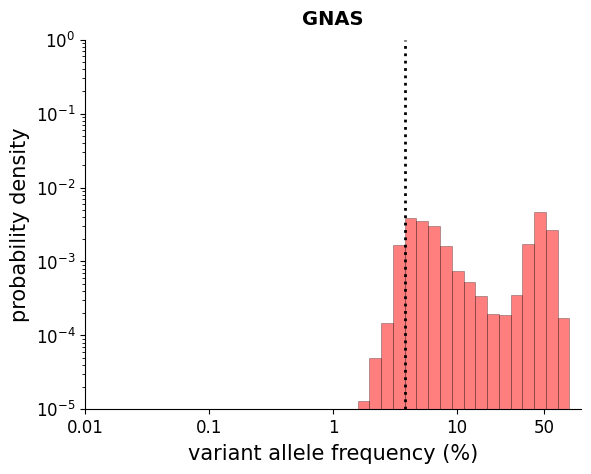

bin edges (log) (IDH2) =  [-1.65321251 -1.55596472 -1.45871692 -1.36146913 -1.26422133 -1.16697354
 -1.06972574 -0.97247795 -0.87523015 -0.77798236 -0.68073456 -0.58348677
 -0.48623897 -0.38899118 -0.29174338 -0.19449559 -0.09724779  0.        ]
densities in each bin (IDH2) =  [  3.  55. 443. 718. 842. 472. 216.  62.  27.  11.  25.  63. 300. 755.
 452.  57.   1.]



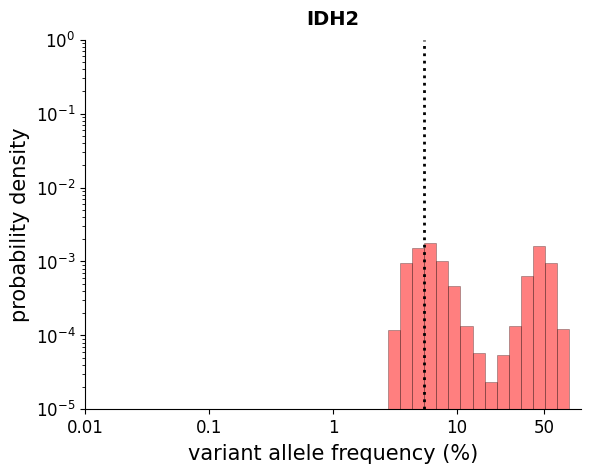

bin edges (log) (MDM4) =  [-1.54818461 -1.46217435 -1.3761641  -1.29015384 -1.20414359 -1.11813333
 -1.03212307 -0.94611282 -0.86010256 -0.77409231 -0.68808205 -0.60207179
 -0.51606154 -0.43005128 -0.34404102 -0.25803077 -0.17202051 -0.08601026
  0.        ]
densities in each bin (MDM4) =  [ 20. 105. 242. 274. 298. 214. 137.  75.  34.  35.  44. 130. 336. 755.
 916. 359.  43.   4.]



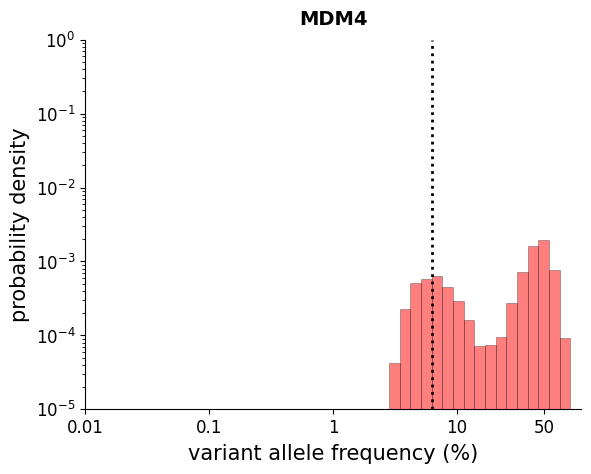

In [19]:
# limit_500k = -1.47931409
binmethod = 'doane' #An improved version of Sturges’ estimator that works better with non-normal datasets.
DNMT3Acolor = "red"
for gene in ['DNMT3A', 'TET2', 'ASXL1', 'CHEK2', 'TP53', 'PPM1D', 'SRSF2', 'SF3B1', 'U2AF1', 'GNAS', 'IDH2', 'MDM4']:
    sub_dict = {key: value for key, value in UKB_all.items() if value[4] == gene}
    all_gene_sorted = sorted(sub_dict.items(), key=lambda x: x[1][1], reverse=True) #sort the results by VAF
    f, ax1 = plt.subplots()
    hist_data_for_plot(all_gene_sorted, used_individuals_500k, binmethod, DNMT3Acolor, gene, limit_500k[gene], ax1)
    plt.show() 

## 4. VAF distribution

21863


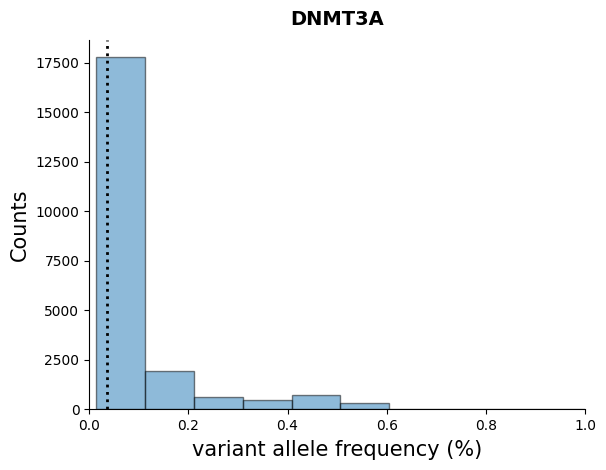

22018


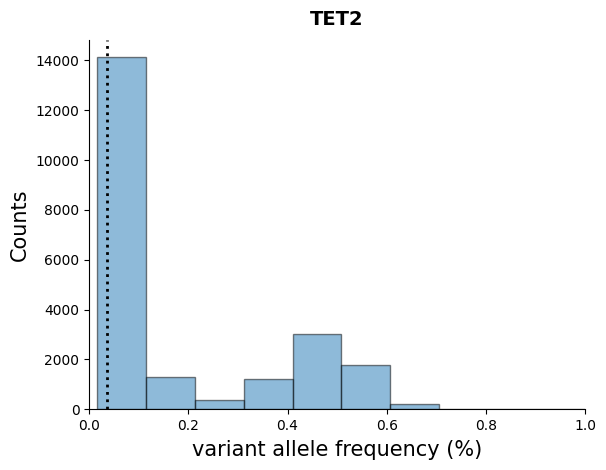

19212


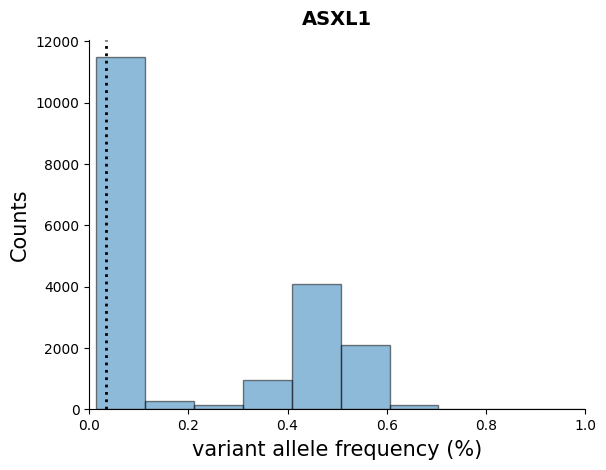

6104


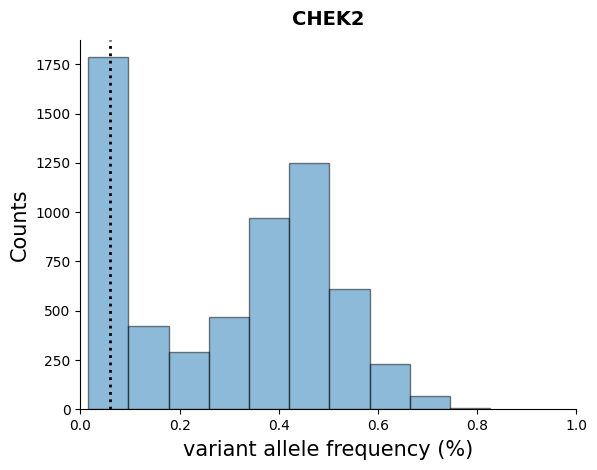

4818


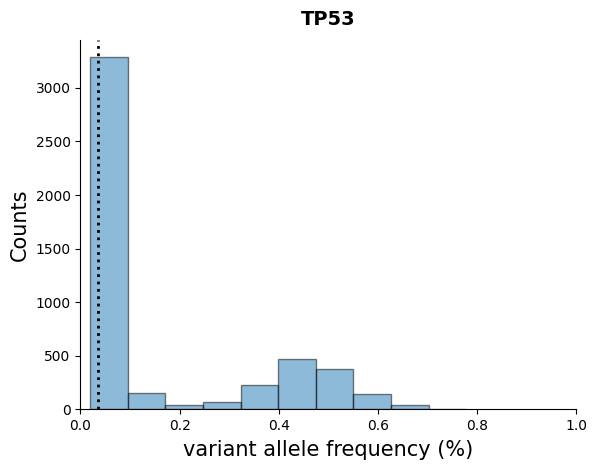

7759


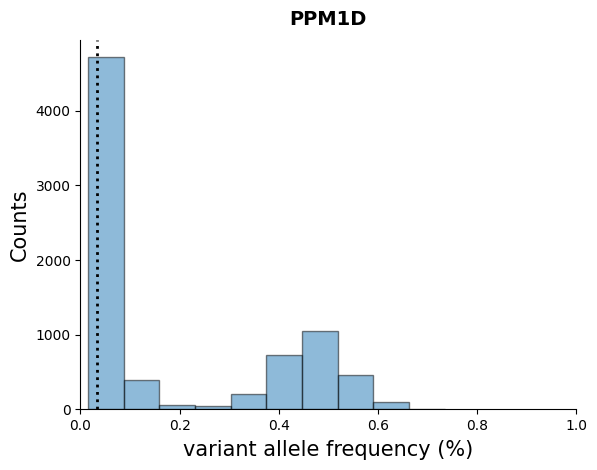

3219


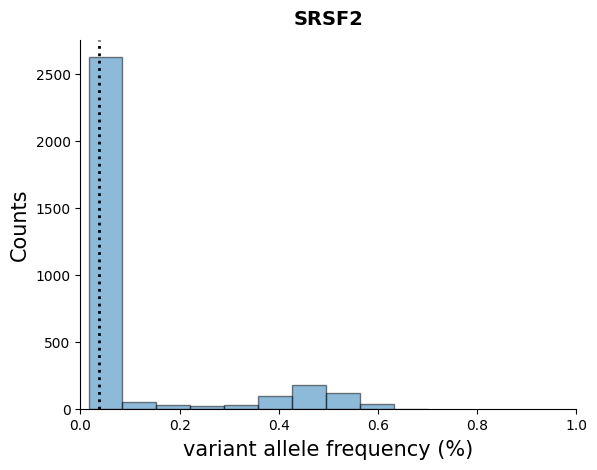

4973


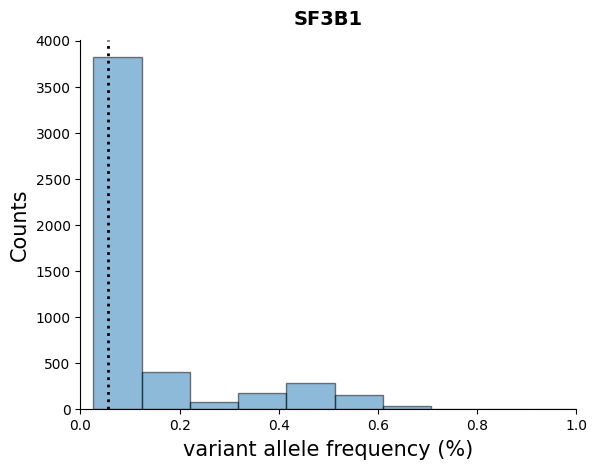

3042


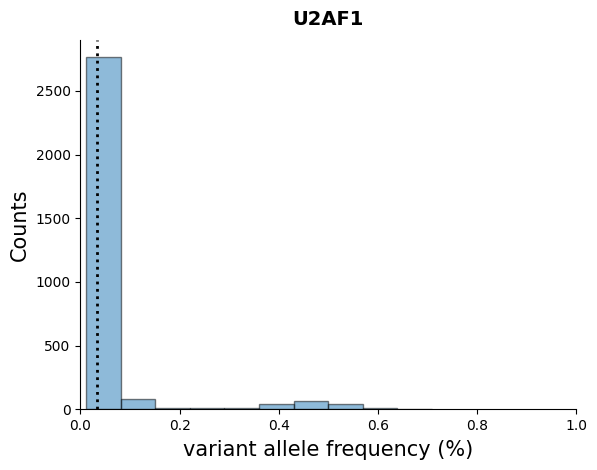

11884


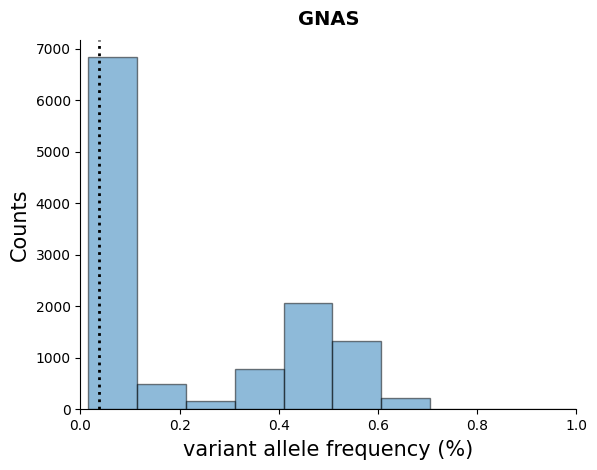

4502


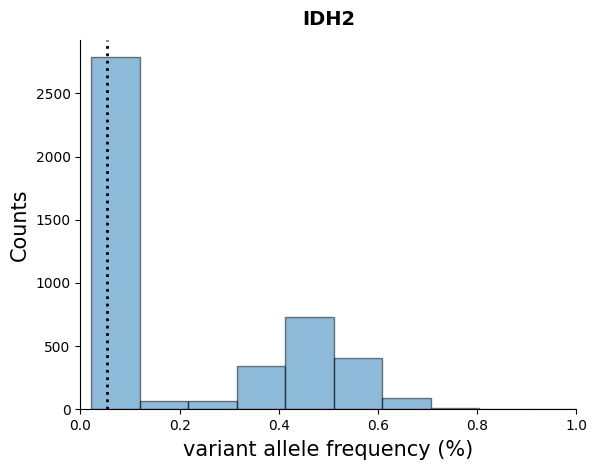

4021


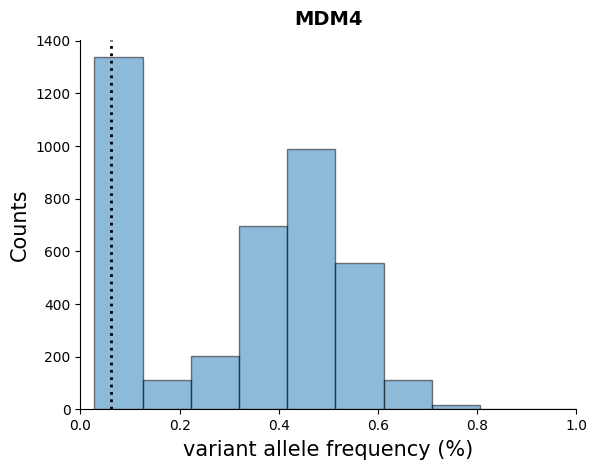

In [20]:
limit_500k = {
    'All':10**(-1.47021882),
    'DNMT3A':10**(-1.44891098),
    'TET2':10**(-1.43749715),
    'ASXL1':10**(-1.47937168),
    'CHEK2':10**(-1.22874631),
    'TP53':10**(-1.43879269),
    'PPM1D':10**(-1.46639745),
    'SRSF2':10**(-1.42301253),
    'SF3B1':10**(-1.25316058),
    'U2AF1':10**(-1.46483105),
    'GNAS':10**(-1.42188989),
    'IDH2':10**(-1.26422133),
    'MDM4':10**(-1.20414359),
}

def mut_dict2mut_list(mut_dict):
    mut_list = []
    for k, v in mut_dict.items():
        mut_list.append(float(v[1]))
    return mut_list

def hist_data_VAF(study_VAFs, study_total, bin_size, color, study_name, trim_VAF_value, axis): #Function to plot histograms of each study, given VAFs and study total
   
    axis.hist(study_VAFs, alpha = 0.5, edgecolor='k', label= study_name) #plot the histogram and label with study name
    axis.set_xlim(0, 1)
    
    axisfont=12
    titlefont=20
    subtitlefont = 15
    axislabelfont=15
    legendfont = 11
    tpfont = 12

    axis.axvline(x=trim_VAF_value, color = 'k', lw =2, linestyle = ':')
    axis.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 5)
    axis.set_ylabel('Counts', fontsize = axislabelfont)

    #Only show the bottom and left axis lines
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # Axis title
    axis.set_title(study_name, fontsize = 14, fontweight = 'semibold', y=1.04, transform=axis.transAxes)
    
    return axis #return the histogram

# limit_500k = -1.47931409
binmethod = 'doane' #An improved version of Sturges’ estimator that works better with non-normal datasets.
DNMT3Acolor = "red"
for gene in ['DNMT3A', 'TET2', 'ASXL1', 'CHEK2', 'TP53', 'PPM1D', 'SRSF2', 'SF3B1', 'U2AF1', 'GNAS', 'IDH2', 'MDM4']:
# for gene in ['CHEK2']:
    sub_dict = {key: value for key, value in UKB_all.items() if value[4] == gene}
    all_gene_sorted = sorted(sub_dict.items(), key=lambda x: x[1][1], reverse=True) #sort the results by VAF
    GENE_ID_all_list = mut_dict2mut_list(sub_dict)
    dat = np.array(GENE_ID_all_list)
    # dat = np.msort(dat)
    print(len(dat))
    f, ax1 = plt.subplots()
    hist_data_VAF(dat, used_individuals_500k, binmethod, DNMT3Acolor, gene, limit_500k[gene], ax1)
    plt.show()